In [1]:
import pandas as pd
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import re
import mlfinlab.data_structures.time_data_structures as time_data_structures

In [2]:
syntheticAsset = pd.read_csv('./data/syntheticAssetsRank.csv')[['ticker', 't-stat', 'pval']]
syntheticAsset.head()

,ticker,t-stat,pval
0,"('SNPS', 'ORLY', 'MDLZ')",-4.686451,0.000595
1,"('SNPS', 'AMD', 'ORLY', 'MDLZ')",-4.679907,0.000611
2,"('NXPI', 'SNPS', 'AMD', 'ORLY', 'MDLZ')",-4.664184,0.000650
3,"('NXPI', 'SNPS', 'ORLY', 'MDLZ')",-4.641019,0.000712
4,"('SNPS', 'XEL', 'ORLY', 'MDLZ')",-4.635005,0.000728


In [3]:
qqqRaw = pd.read_csv("./data/qqq.csv")
snpsRaw = pd.read_csv("./data/snps.csv")
orlyRaw = pd.read_csv("./data/orly.csv")
mdlzRaw = pd.read_csv("./data/mdlz.csv")

qqqRaw = qqqRaw[['DATE', 'TIME_M', 'PRICE', 'SIZE']]
snpsRaw = snpsRaw[['DATE', 'TIME_M', 'PRICE', 'SIZE']]
orlyRaw = orlyRaw[['DATE', 'TIME_M', 'PRICE', 'SIZE']]
mdlzRaw = mdlzRaw[['DATE', 'TIME_M', 'PRICE', 'SIZE']]

In [4]:
def cleanTickData(df):
    year = df['DATE'] // 10000
    month = df['DATE'] // 100 % 100
    day = df['DATE'] % 100
    date_time = month.astype(str) + '/' + day.astype(str) + '/' + year.astype(str) + ' ' + df['TIME_M']
    new_data = pd.concat([pd.to_datetime(date_time, infer_datetime_format=True), df['PRICE'], df['SIZE']], axis=1)
    new_data.columns = ['date', 'price', 'volume']
    print('DONE!')
    return new_data

In [5]:
qqqClean = cleanTickData(qqqRaw)
snpsClean = cleanTickData(snpsRaw)
orlyClean = cleanTickData(orlyRaw)
mdlzClean = cleanTickData(mdlzRaw)

DONE!
DONE!
DONE!
DONE!


In [6]:
def getMinuteData(df):
    minuteDf = time_data_structures.get_time_bars(df, resolution='MIN', batch_size=10000000)
    minuteDf['date_time'] = pd.to_datetime(minuteDf['date_time'], unit='s')
    return minuteDf

In [7]:
qqq = getMinuteData(qqqClean)
snps = getMinuteData(snpsClean)
orly = getMinuteData(orlyClean)
mdlz = getMinuteData(mdlzClean)

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 

Reading data in batches:
Batch number: 0
Returning bars 

Reading data in batches:
Batch number: 0
Returning bars 

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



In [95]:
qqq = qqq.set_index('date_time')
qqq = qqq.rename(columns={'close': 'qqqclose'})

snps = snps.set_index('date_time')
snps = snps.rename(columns={'close': 'snpsclose'})

orly = orly.set_index('date_time')
orly = orly.rename(columns={'close': 'orlyclose'})

mdlz = mdlz.set_index('date_time')
mdlz = mdlz.rename(columns={'close': 'mdlzclose'})

data = qqq[['qqqclose']].join([snps[['snpsclose']], orly[['orlyclose']], mdlz[['mdlzclose']]], how='outer')
data = data.ffill()
data.tail(20)


KeyError: "None of ['date_time'] are in the columns"

In [96]:
data.to_csv('./data/joinedMinuteData20192020.csv')

In [9]:
syntheticAssetPrice = data['snpsclose'] + data['orlyclose'] + data['mdlzclose']
syntheticAssetLogPrice = np.log(syntheticAssetPrice.values)
qqqLogPrice = np.log(data['qqqclose'].values)

# Adapt to multivariate Kalman Filter
obs_mat = sm.add_constant(syntheticAssetLogPrice, prepend=False)[:, np.newaxis]
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)
firstY = np.log(qqqLogPrice[0])
firstX = np.log(syntheticAssetLogPrice[0])
kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 2,
                  initial_state_mean = [firstY / firstX, 0.0],
                  initial_state_covariance = np.ones((2,2)),
                  transition_matrices = np.eye(2), 
                  observation_matrices = obs_mat,
                  observation_covariance = 0.5,
                  transition_covariance= trans_cov)

In [10]:
state_means, state_covs = kf.filter(qqqLogPrice)
slope=state_means[:, 0] 
intercept=state_means[:, 1]

Text(0, 0.5, 'intercept')

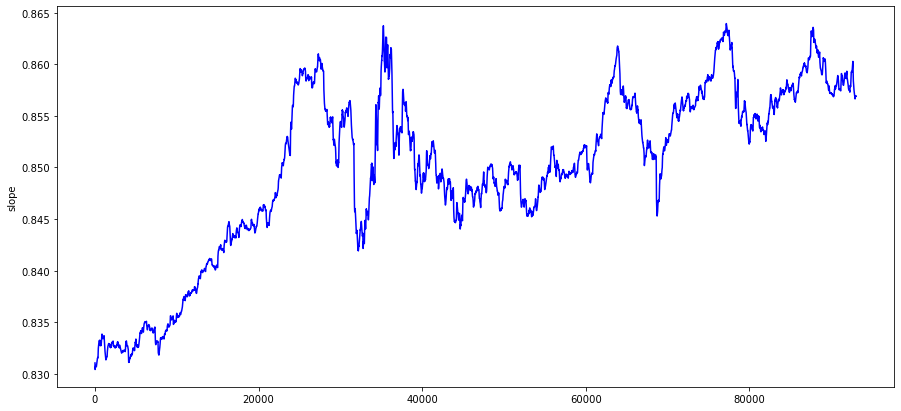

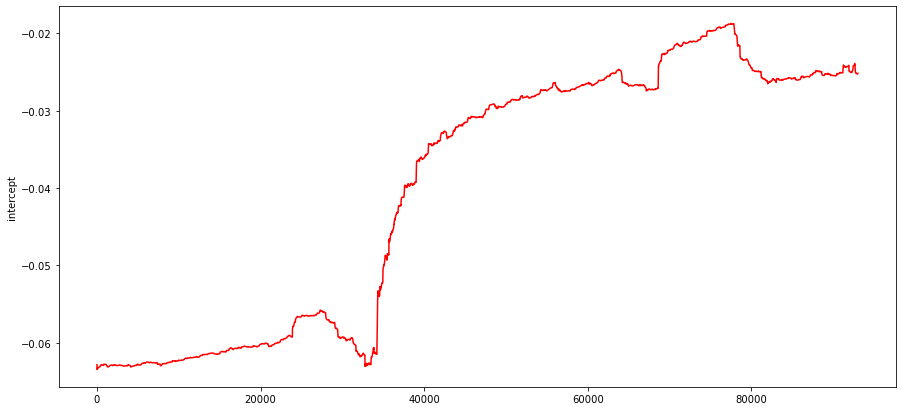

In [11]:
plt.figure(figsize =(15,7))
plt.plot(slope, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(intercept,c='r')
plt.ylabel('intercept')

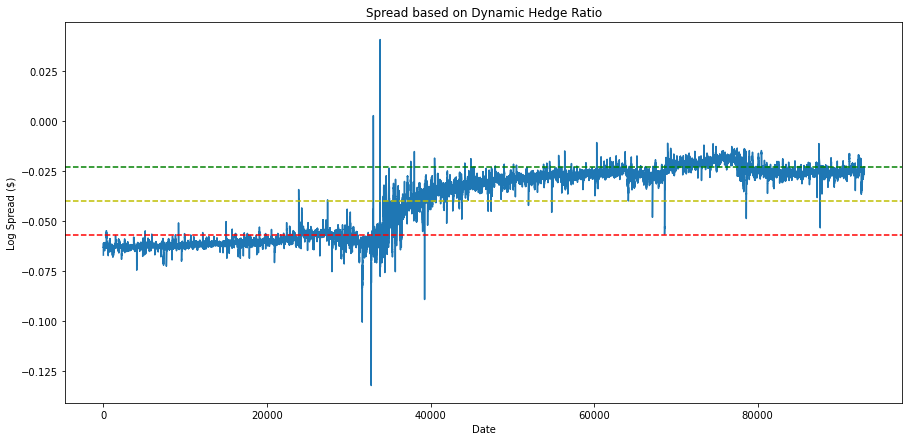

In [12]:
spread_ts = qqqLogPrice - slope * syntheticAssetLogPrice
plt.figure(figsize = (15,7))
plt.plot(spread_ts)
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Log Spread ($)")
plt.xlabel("Date")
spread_avg = spread_ts.mean()
spread_sd = spread_ts.std()
upper_threshold = spread_avg + spread_sd
lower_threshold = spread_avg - spread_sd
plt.axhline(upper_threshold, linestyle = 'dashed', color = 'g')
plt.axhline(spread_avg, linestyle = 'dashed', color = 'y')
plt.axhline(lower_threshold, linestyle = 'dashed', color = 'r')

In [14]:
data.reset_index(level=0, inplace=True)
data['logspread'] = spread_ts
data['dayperiod'] = data['date_time'].dt.to_period('D')
data.tail()

,date_time,qqqclose,snpsclose,orlyclose,mdlzclose,logspread,dayperiod
93026,2020-10-30 15:45:00,268.3200,213.420,435.9357,52.900,-0.024245,2020-10-30
93027,2020-10-30 15:46:00,268.4700,213.500,435.6392,52.930,-0.023507,2020-10-30
93028,2020-10-30 15:47:00,268.1300,213.140,435.2850,52.825,-0.023814,2020-10-30
93029,2020-10-30 15:48:00,267.7400,212.600,435.3100,52.775,-0.024595,2020-10-30
93030,2020-10-30 15:49:00,267.5799,212.515,435.5100,52.700,-0.025240,2020-10-30


In [15]:
data.to_csv('./data/spreadDf2019to2020.csv')

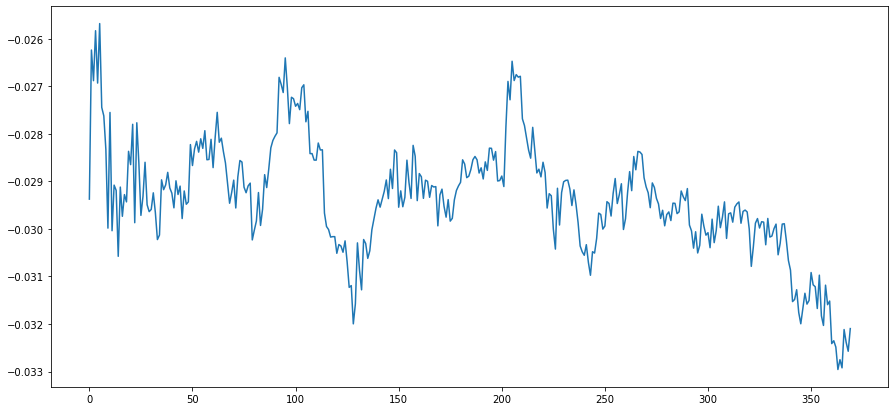

In [94]:
day = data.loc[data['dayperiod'] == '2020-5-12']
plt.figure(figsize = (15,7))
plt.plot(day['logspread'].values)

In [97]:
spread_df = data[['date_time', 'logspread', 'dayperiod']]
spread_df['hedgeRatio'] = slope

lookback = 180
spread_df['spread'] = np.exp(spread_df['logspread'])
spread_df['returns'] = spread_df['spread'].diff() / spread_df['spread'].abs().shift()
spread_df['ema'] = spread_df['spread'].ewm(span=lookback).mean()

constant = 1
rolling_std = spread_df['spread'].rolling(lookback).std()
spread_df['upperband'] = spread_df['ema'] + (constant * rolling_std)
spread_df['lowerband'] = spread_df['ema'] - (constant * rolling_std)

spread_df['aboveOrBelowEMA'] = np.where(spread_df['spread'] > spread_df['ema'], 1, -1)
spread_df = spread_df.iloc[lookback:]
spread_df

<ipython-input-97-d42cf1218f81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['hedgeRatio'] = slope
<ipython-input-97-d42cf1218f81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['spread'] = np.exp(spread_df['logspread'])
<ipython-input-97-d42cf1218f81>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,date_time,logspread,dayperiod,hedgeRatio,spread,returns,ema,upperband,lowerband,aboveOrBelowEMA
180,2019-11-01 12:41:00,-0.062331,2019-11-01,0.830752,0.939572,0.000298,0.938849,0.939757,0.937941,1
181,2019-11-01 12:42:00,-0.062394,2019-11-01,0.830756,0.939512,-0.000064,0.938858,0.939760,0.937955,1
182,2019-11-01 12:43:00,-0.062495,2019-11-01,0.830759,0.939418,-0.000100,0.938865,0.939747,0.937982,1
183,2019-11-01 12:44:00,-0.062752,2019-11-01,0.830761,0.939176,-0.000258,0.938869,0.939738,0.937999,1
184,2019-11-01 12:45:00,-0.062382,2019-11-01,0.830765,0.939524,0.000371,0.938877,0.939734,0.938020,1
...,...,...,...,...,...,...,...,...,...,...
93026,2020-10-30 15:45:00,-0.024245,2020-10-30,0.856907,0.976047,-0.000011,0.974911,0.976292,0.973530,1
93027,2020-10-30 15:46:00,-0.023507,2020-10-30,0.856915,0.976767,0.000738,0.974931,0.976311,0.973551,1
93028,2020-10-30 15:47:00,-0.023814,2020-10-30,0.856921,0.976468,-0.000306,0.974948,0.976329,0.973568,1
93029,2020-10-30 15:48:00,-0.024595,2020-10-30,0.856923,0.975705,-0.000781,0.974957,0.976333,0.973581,1


In [82]:
spread_df['position'] = np.where(spread_df['spread'] > spread_df['upperband'], -1, np.nan)
spread_df['position'] = np.where(spread_df['spread'] < spread_df['lowerband'], 1, spread_df['position'])
spread_df['position'] = np.where(spread_df['aboveOrBelowEMA'] * spread_df['aboveOrBelowEMA'].shift(1) < 0, 
                                 0, spread_df['position'])
spread_df['position'] = spread_df['position'].ffill().fillna(0)

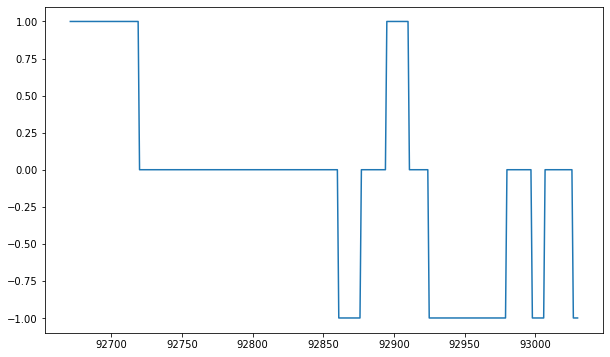

In [83]:
spread_df['position'].iloc[-360:].plot(ylim=[-1.1, 1.1], figsize=(10, 6))

Positions are opened with the hedge ratio corresponding to that minute and the hedge ratio changes by the next minute.  Returns on this position should be calculated by the returns of opening the position at t_open with hedge ratio of t_open and closing the position at t_close with hedge ratio of t_open.  

In [84]:
spread_df['strategyReturns'] = spread_df['position'].shift(1) * spread_df['returns']
spread_df.tail(20)

,date_time,logspread,dayperiod,spread,returns,ema,upperband,lowerband,aboveOrBelowEMA,position,strategyReturns
93011,2020-10-30 15:30:00,-0.025669,2020-10-30,0.974657,-0.000577,0.974917,0.976343,0.973491,-1,0.0,-0.000000
93012,2020-10-30 15:31:00,-0.025159,2020-10-30,0.975155,0.000511,0.974920,0.976346,0.973493,1,0.0,0.000000
93013,2020-10-30 15:32:00,-0.025246,2020-10-30,0.975070,-0.000087,0.974921,0.976347,0.973496,1,0.0,-0.000000
93014,2020-10-30 15:33:00,-0.025385,2020-10-30,0.974935,-0.000139,0.974921,0.976344,0.973499,1,0.0,-0.000000
93015,2020-10-30 15:34:00,-0.025787,2020-10-30,0.974542,-0.000403,0.974917,0.976339,0.973496,-1,0.0,-0.000000
93016,2020-10-30 15:35:00,-0.026128,2020-10-30,0.974210,-0.000341,0.974909,0.976331,0.973488,-1,0.0,-0.000000
93017,2020-10-30 15:36:00,-0.025869,2020-10-30,0.974463,0.000259,0.974905,0.976323,0.973486,-1,0.0,0.000000
93018,2020-10-30 15:37:00,-0.026230,2020-10-30,0.974111,-0.000361,0.974896,0.976309,0.973482,-1,0.0,-0.000000
93019,2020-10-30 15:38:00,-0.026296,2020-10-30,0.974047,-0.000066,0.974886,0.976295,0.973478,-1,0.0,-0.000000
93020,2020-10-30 15:39:00,-0.026064,2020-10-30,0.974272,0.000232,0.974880,0.976281,0.973478,-1,0.0,0.000000


In [85]:
spread_df['strategyReturns'] = spread_df['strategyReturns'] + 1

In [86]:
dailyReturns = spread_df.groupby(['dayperiod'])["strategyReturns"].apply(lambda g: g.cumprod().iloc[-1] - 1)
dailyReturns.loc[dailyReturns > 0.125]

dayperiod
2020-03-16    0.188279
Freq: D, Name: strategyReturns, dtype: float64

(array([112., 100.,  24.,   6.,   5.,   2.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.]),
 array([-2.82974322e-05,  1.25255400e-02,  2.50793774e-02,  3.76332149e-02,
         5.01870523e-02,  6.27408898e-02,  7.52947272e-02,  8.78485646e-02,
         1.00402402e-01,  1.12956240e-01,  1.25510077e-01,  1.38063914e-01,
         1.50617752e-01,  1.63171589e-01,  1.75725427e-01,  1.88279264e-01]),
 <a list of 15 Patch objects>)

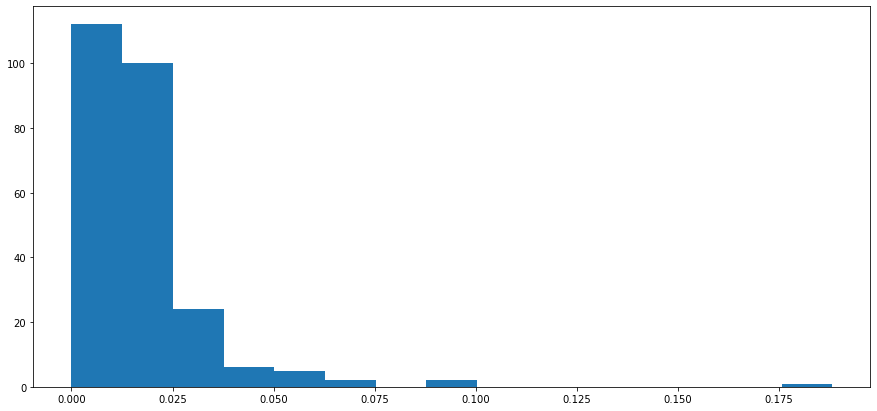

In [87]:
plt.figure(figsize=[15, 7])
plt.hist(dailyReturns, bins=15)

In [88]:
dailyReturns = dailyReturns.reset_index()
dailyReturns['dayperiod'] = [dailyReturns['dayperiod'].iloc[i].to_timestamp() for i in range(len(dailyReturns))]
dailyReturns = dailyReturns.set_index('dayperiod')

In [89]:
dailyReturns.tail(22)

,strategyReturns
dayperiod,
2020-10-01,0.014106
2020-10-02,0.016090
2020-10-05,0.004557
2020-10-06,0.016055
2020-10-07,0.021315
2020-10-08,0.020667
2020-10-09,0.004344
2020-10-12,0.001982
2020-10-13,0.007422


In [90]:
r_series = dailyReturns['strategyReturns'] + 1
aggYearReturn = r_series.cumprod() - 1
print('Strategy Return from 11-01-2019 to 10-31-2020: ', aggYearReturn[-1] * 100, '%')

Strategy Return from 11-01-2019 to 10-31-2020:  7488.0308955233995 %
